## Introduction
Depuis les années 2010, une importante compétition annuelle dans le domaine de l’intelligence artificielle et des réseaux de neurones se déroule. Il s’agit de la ILSVRC (ImageNet Large Scale Visual Recognition Challenge). ImageNet est un jeu de données contenant 1,2 million d’images et 1000 classes d’images différentes (2012). En 2012, les architectures CNN (Convolutional Neural Networks) révolutionnent le domaine de la reconnaissance d’images. En effet, le taux d’erreur en 2012 est quasiment la moitié de celui de l’année précédente. Dans le cadre du cours, nous analyserons la classification d’images avec trois réseaux de neurones convolutifs profonds abordés dans trois articles scientifiques. Nous expliquerons en détail comment fonctionnent les CNNs et pourquoi ces réseaux sont plus efficaces que les techniques de classification traditionnelles comme les machines à vecteurs de support (SVM) et les réseaux de neurones profonds classiques (Deep NN).

## AlexNet
Nous discuterons de l’architecture d’**AlexNet** et des concepts de Dropout, d’utilisation de la fonction ReLu (Rectified non Linear unit) et de ses avantages et du preprocessing d’images (data augmentation, normalization), présentés dans le papier: https://www.cs.toronto.edu/~kriz/imagenet_classification_with_deep_convolutional.pdf. Les hyper paramètres seront ajustés.

## VGG
Nous aborderons l’architecture de **VGG**, notamment des aspects présentés dans le papier: https://arxiv.org/pdf/1409.1556.pdf. Les hyper paramètres seront ajustés.

## ResNet
Nous verrons l’architecture de **ResNet** ainsi que le concept de Residual Learning, présentés dans le papier: https://arxiv.org/pdf/1512.03385.pdf. Les hyper paramètres seront ajustés.

## Plan d’exécution
Nous implémenterons ces trois architectures et nous allons entraîner ces modèles sur le jeu de données CIFAR-10. Ce jeu de données contient 60 000 images et 10 classes différentes. À la suite de cela, nous analyserons l’impact des différents paramètres sur la performance de nos trois architectures et nous conclurons sur une configuration la plus optimale possible (dans les limites du temps qui nous est accordé et de la performance de nos GPUs) pour chacune des trois architectures. Finalement, nous proposerons une architecture finale pour classifier le jeu de données CIFAR-10.


170500096/170498071 [==============================] - 6s 0us/step
Training:	X=(40000, 32, 32, 3)	y=(40000, 10)
Validation:	X=(10000, 32, 32, 3)	y=(10000, 10)
Test:		X=(10000, 32, 32, 3)	y=(10000, 10)


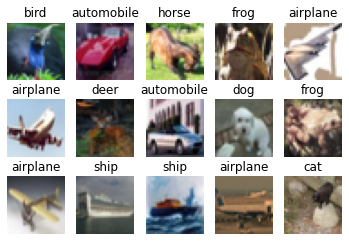

In [1]:
import numpy as np
from keras.applications import VGG16, ResNet50, ResNet101
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

# Load CIFAR-10 dataset : 40,000 for training
#                         10,000 for validation
#                         10,100 for test
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train, test_size=0.2)
(y_train, y_valid, y_test) = (to_categorical(y_train), to_categorical(y_valid), to_categorical(y_test))
print(f"Training:\tX={X_train.shape}\ty={y_train.shape}\nValidation:\tX={X_valid.shape}\ty={y_valid.shape}\nTest:\t\tX={X_test.shape}\ty={y_test.shape}")

# Plot 15 images from the dataset
rows, columns = 3, 5
for i in range(rows * columns):
    img = plt.subplot(rows, columns, i + 1)
    img.set_title(classes[np.argmax(y_train[i])])
    plt.axis("off")
    plt.imshow(X_train[i])
plt.show()

https://keras.io/api/models/model_training_apis/

In [2]:
def plot(logs):
    plt.plot(range(epochs), logs.history["loss"], "r", label="Training loss")
    plt.plot(range(epochs), logs.history["val_loss"], "b", label="Validation loss")
    plt.title("Loss")
    plt.legend(loc=0)
    plt.figure()

    plt.plot(range(epochs), logs.history["accuracy"], "r", label="Training")
    plt.plot(range(epochs), logs.history["val_accuracy"], "b", label="Validation")
    plt.title("Accuracy")
    plt.legend(loc=0)
    plt.figure()

## Data preprocessing

In [3]:
# Z-score
X_train = (X_train - np.mean(X_train, axis=(0, 1, 2, 3))) / (np.std(X_train, axis=(0, 1, 2, 3)) + 1e-7)
X_valid = (X_valid - np.mean(X_valid, axis=(0, 1, 2, 3))) / (np.std(X_valid, axis=(0, 1, 2, 3)) + 1e-7)
X_test = (X_test - np.mean(X_test, axis=(0, 1, 2, 3))) / (np.std(X_test, axis=(0, 1, 2, 3)) + 1e-7)

# Data augmentation
gen = ImageDataGenerator(
      rotation_range=15,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
)

## AlexNet

In [6]:
# Original paper: https://www.cs.toronto.edu/~kriz/imagenet_classification_with_deep_convolutional.pdf
alexnet = Sequential()

alexnet.add(Conv2D(filters=96, input_shape=X_train.shape[1:], kernel_size=(11, 11), strides=(4, 4), padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(Activation("relu"))
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same"))

alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(Activation("relu"))
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same"))

alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(Activation("relu"))

alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(Activation("relu"))

alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(Activation("relu"))
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same"))

alexnet.add(Flatten())

alexnet.add(Dense(4096, input_shape=(32,32,3,)))
alexnet.add(BatchNormalization())
alexnet.add(Activation("relu"))
alexnet.add(Dropout(0.5))

alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation("relu"))
alexnet.add(Dropout(0.5))

alexnet.add(Dense(1000))
alexnet.add(BatchNormalization())
alexnet.add(Activation("relu"))

alexnet.add(Dense(len(classes)))
alexnet.add(BatchNormalization())
alexnet.add(Activation("softmax"))

alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 96)          384       
_________________________________________________________________
activation_9 (Activation)    (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_10 (Activation)   (None, 4, 4, 256)        

Epoch 1/100
313/313 [==============================] - 24s 70ms/step - loss: 2.0145 - accuracy: 0.2651 - val_loss: 1.7469 - val_accuracy: 0.3730
Epoch 2/100
313/313 [==============================] - 22s 69ms/step - loss: 1.6219 - accuracy: 0.4144 - val_loss: 1.4221 - val_accuracy: 0.4773
Epoch 3/100
313/313 [==============================] - 22s 70ms/step - loss: 1.5023 - accuracy: 0.4565 - val_loss: 1.2936 - val_accuracy: 0.5371
Epoch 4/100
313/313 [==============================] - 22s 70ms/step - loss: 1.4244 - accuracy: 0.4875 - val_loss: 1.2352 - val_accuracy: 0.5530
Epoch 5/100
313/313 [==============================] - 22s 70ms/step - loss: 1.3572 - accuracy: 0.5138 - val_loss: 1.2358 - val_accuracy: 0.5616
Epoch 6/100
313/313 [==============================] - 22s 69ms/step - loss: 1.3089 - accuracy: 0.5344 - val_loss: 1.2187 - val_accuracy: 0.5664
Epoch 7/100
313/313 [==============================] - 22s 69ms/step - loss: 1.2816 - accuracy: 0.5435 - val_loss: 1.1573 - val_ac

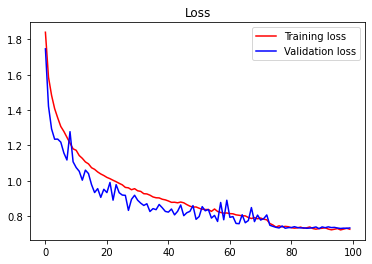

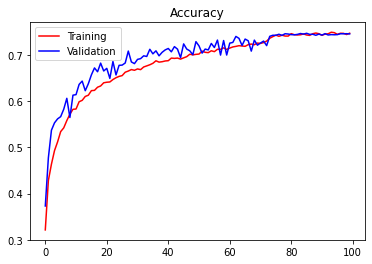

<Figure size 432x288 with 0 Axes>

In [7]:
# Hyperparameters
loss = categorical_crossentropy
lr = 0.01
momentum = 0.9
decay = 0.0005
epochs = 100
batch_size = 128
optimizer = SGD(learning_rate=lr, momentum=momentum, decay=decay)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, verbose=1)

alexnet.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"]
)

logs = alexnet.fit(gen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr_on_plateau]
)

plot(logs)

In [9]:
# Results on test set
loss, accuracy = alexnet.evaluate(X_test, y_test)
print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")

313/313 [==============================] - 1s 3ms/step - loss: 0.7550 - accuracy: 0.7383
Loss on test set: 0.7550408244132996
Accuracy on test set: 0.7383000254631042


## VGG

In [ ]:
# VGG: https://keras.io/api/applications/vgg
# Original paper: https://arxiv.org/pdf/1409.1556.pdf
vgg = VGG16(
    input_shape=X_train.shape[1:],
    weights=None,
    pooling="max",
    classes=len(classes)
)

# Add dropout
vgg_with_dropout = Sequential()
for layer in vgg.layers:
    vgg_with_dropout.add(layer)
    if layer.name in ["fc1", "fc2"]:
        vgg_with_dropout.add(Dropout(0.5))

vgg = vgg_with_dropout

vgg.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

Epoch 1/100
157/157 [==============================] - 25s 145ms/step - loss: 2.3026 - accuracy: 0.1004 - val_loss: 2.3024 - val_accuracy: 0.0952
Epoch 2/100
157/157 [==============================] - 22s 142ms/step - loss: 2.3018 - accuracy: 0.1045 - val_loss: 2.2976 - val_accuracy: 0.1026
Epoch 3/100
157/157 [==============================] - 22s 139ms/step - loss: 2.2789 - accuracy: 0.1455 - val_loss: 2.1200 - val_accuracy: 0.2028
Epoch 4/100
157/157 [==============================] - 22s 141ms/step - loss: 2.0980 - accuracy: 0.1957 - val_loss: 1.9493 - val_accuracy: 0.2140
Epoch 5/100
157/157 [==============================] - 22s 140ms/step - loss: 1.9903 - accuracy: 0.2107 - val_loss: 1.8864 - val_accuracy: 0.2522
Epoch 6/100
157/157 [==============================] - 22s 138ms/step - loss: 1.9108 - accuracy: 0.2459 - val_loss: 1.7963 - val_accuracy: 0.2781
Epoch 7/100
157/157 [==============================] - 22s 140ms/step - loss: 1.8129 - accuracy: 0.2897 - val_loss: 1.7136 -

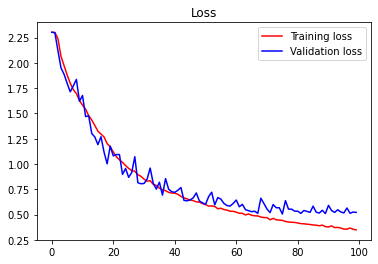

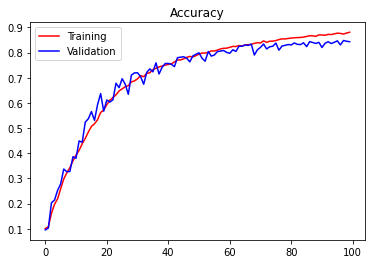

<Figure size 432x288 with 0 Axes>

In [ ]:
# Hyperparameters
loss = categorical_crossentropy
lr = 0.01
momentum = 0.9
decay = 0.0005
epochs = 100
batch_size = 256
optimizer = SGD(learning_rate=lr, momentum=momentum, decay=decay)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, verbose=1)

vgg.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"]
)

logs = vgg.fit(gen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr_on_plateau]
)

plot(logs)

In [ ]:
# Results on test set
loss, accuracy = vgg.evaluate(X_test, y_test)
print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")

313/313 [==============================] - 1s 5ms/step - loss: 0.5265 - accuracy: 0.8428
Loss on test set: 0.5264959335327148
Accuracy on test set: 0.8428000211715698


## ResNet

In [ ]:
# ResNet: https://keras.io/api/applications/resnet
# Original paper: https://arxiv.org/pdf/1512.03385.pdf
resnet = ResNet50(
    input_shape=X_train.shape[1:],
    weights=None,
    pooling="max",
    classes=len(classes),
)

Epoch 1/100
157/157 [==============================] - 31s 166ms/step - loss: 2.3074 - accuracy: 0.1877 - val_loss: 3.3704 - val_accuracy: 0.0987
Epoch 2/100
157/157 [==============================] - 25s 160ms/step - loss: 2.3180 - accuracy: 0.1752 - val_loss: 2.2656 - val_accuracy: 0.1969
Epoch 3/100
157/157 [==============================] - 25s 159ms/step - loss: 2.1229 - accuracy: 0.2160 - val_loss: 2.0660 - val_accuracy: 0.2342
Epoch 4/100
157/157 [==============================] - 25s 159ms/step - loss: 2.0558 - accuracy: 0.2384 - val_loss: 2.0155 - val_accuracy: 0.2306
Epoch 5/100
157/157 [==============================] - 25s 159ms/step - loss: 2.0146 - accuracy: 0.2570 - val_loss: 1.9907 - val_accuracy: 0.2429
Epoch 6/100
157/157 [==============================] - 25s 161ms/step - loss: 1.9140 - accuracy: 0.2763 - val_loss: 1.9590 - val_accuracy: 0.2749
Epoch 7/100
157/157 [==============================] - 25s 161ms/step - loss: 1.8723 - accuracy: 0.2915 - val_loss: 1.8511 -

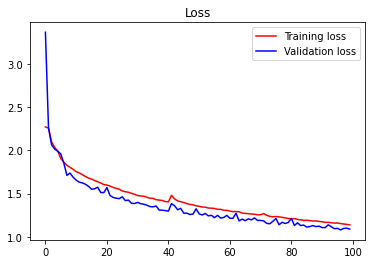

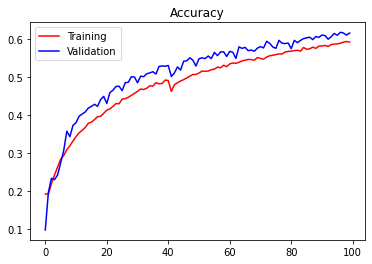

<Figure size 432x288 with 0 Axes>

In [ ]:
# Hyperparameters
loss = categorical_crossentropy
lr = 0.1
momentum = 0.9
decay = 0.0001
epochs = 100
batch_size = 256
optimizer = SGD(learning_rate=lr, momentum=momentum, decay=decay)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, verbose=1)

resnet.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"],
)

logs = resnet.fit(gen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr_on_plateau]
)

plot(logs)

In [ ]:
# Results on test set
loss, accuracy = resnet.evaluate(X_test, y_test)
print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")

313/313 [==============================] - 3s 10ms/step - loss: 1.0914 - accuracy: 0.6124
Loss on test set: 1.0914406776428223
Accuracy on test set: 0.6123999953269958
